# AMATH 563 Spring Quarter 2020
## Homework 2: Dynamics and Model Discovery
### DUE: Wednesday, May 6, 2020

#### Ashwin Srinivas Badrinath


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.interpolate import interp1d
from information_scores import *

In [2]:
# Layout the lynx and hare data

time = np.arange(0,1905-1845,2) # original time 

hare = (np.array([20,20,52,83,64,68,83,12,3,150,110,
                  60,7,10,70,100,92,70,10,11,137,137,
                  18,22,52,83,18,10,9,65])) # original hare population values


lynx = (np.array([32,50,12,10,13,36,15,12,6,6,65,70,
                  40,9,20,34,45,40,15,15,60,80,26,18,
                  37,50,35,12,12,25])) # original lynx population values

time_new = np.linspace(0,1903-1845,500) # new time value

dt = np.abs(time_new[1]-time_new[2]) # the new time step

f_hare = interp1d(time,hare,'cubic') # hare inteprolation function

hare_interp = f_hare(time_new) # inteprolated hare population values

f_lynx = interp1d(time,lynx,'cubic') # lynx interpolation function

lynx_interp = f_lynx(time_new) # interpolated lynx population values

X = np.abs(np.vstack([hare_interp,lynx_interp])) # data matrix

# create the X and Xprime matrices to pass to the DMD function
Xprime = X[:,1:]
X = X[:,:-1]

print(X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

(2, 499) (2, 499)


In [3]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [4]:
# obtain DMD model
r = 100 # enter the value of r
Phi, Lambda, b = DMD(X,Xprime,r)
omega = np.log(np.diag(Lambda))/dt
print('Phi =',Phi,'\n')
print('Lambda =',Lambda,'\n')
print('b = ',b,'\n')
print('Omega =',omega)


Phi = [[-0.86251614-0.11708172j -0.86251614+0.11708172j]
 [-0.43764843+0.21533817j -0.43764843-0.21533817j]] 

Lambda = [[0.99763954+0.01625536j 0.        +0.j        ]
 [0.        +0.j         0.99763954-0.01625536j]] 

b =  [-16.99216589-39.7672424j -16.99216589+39.7672424j] 

Omega = [-0.01919019+0.1401706j -0.01919019-0.1401706j]


In [5]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics = np.zeros([2,len(time_new)-1])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*time_new[i])
    
X_dmd = np.abs(np.dot(Phi,time_dynamics))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


Text(0, 0.5, 'Population')

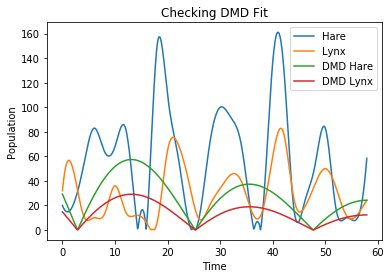

In [6]:
# plot to compare the DMD modes to the actual data
t = time_new[:-1]
plt.plot(t,X[0,:],label='Hare')
plt.plot(t,X[1,:],label='Lynx')
plt.plot(t,X_dmd[0,:],label='DMD Hare')
plt.plot(t,X_dmd[1,:],label='DMD Lynx')
plt.legend()
plt.title("Checking DMD Fit")
plt.xlabel('Time')
plt.ylabel('Population')

(50, 449)


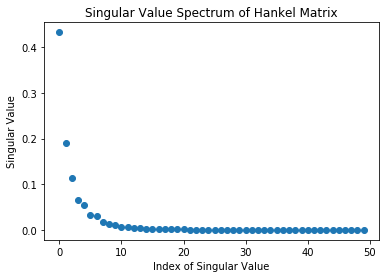

In [7]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 50 # Number of shift-stacked rows
r = 3     # rank of HAVOK model
H = np.zeros((stackmax,X.shape[1]-stackmax))

for k in range(0,stackmax,2):
    H[k:k+2,:] = X[:,k:-(stackmax-k)]
  
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)

In [8]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 2 # enter the value of r
Phi_delay, Lambda_delay, b_delay = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay)


(50, 448) (50, 448)
Phi = [[-0.15519953+0.09266772j -0.15519953-0.09266772j]
 [-0.07007268+0.03180439j -0.07007268-0.03180439j]
 [-0.15946976+0.09399375j -0.15946976-0.09399375j]
 [-0.07173467+0.03521336j -0.07173467-0.03521336j]
 [-0.16352018+0.09301426j -0.16352018-0.09301426j]
 [-0.07342466+0.0379835j  -0.07342466-0.0379835j ]
 [-0.16725303+0.08966128j -0.16725303-0.08966128j]
 [-0.07512106+0.04003423j -0.07512106-0.04003423j]
 [-0.17057983+0.08394634j -0.17057983-0.08394634j]
 [-0.07679921+0.04130196j -0.07679921-0.04130196j]
 [-0.173423  +0.07596069j -0.173423  -0.07596069j]
 [-0.07843249+0.04174203j -0.07843249-0.04174203j]
 [-0.17571684+0.06587173j -0.17571684-0.06587173j]
 [-0.07999328+0.04133002j -0.07999328-0.04133002j]
 [-0.17740834+0.05391697j -0.17740834-0.05391697j]
 [-0.08145383+0.04006229j -0.08145383-0.04006229j]
 [-0.17845838+0.04039753j -0.17845838-0.04039753j]
 [-0.08278737+0.03795686j -0.08278737-0.03795686j]
 [-0.17884291+0.02566988j -0.17884291-0.02566988j]
 [-0.

In [9]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([2,X_delay.shape[1]-1])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*time_new[i])
    
X_dmd_delay = np.abs(np.dot(Phi_delay,time_dynamics_delay))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


Text(0, 0.5, 'Population')

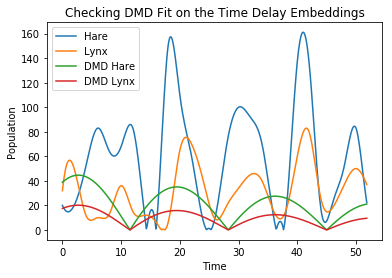

In [10]:
X_dmd_delay_model = X_dmd_delay[0:2,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[0,:end_delay],label='Hare')
plt.plot(t_delay,X[1,:end_delay],label='Lynx')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='DMD Hare')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='DMD Lynx')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('Population')

## Compute Information Scores

In [11]:
# hare data to pass to information score functions
hare_data = X[0,:]
hare_model = X_dmd[0,:]

hare_data_delay = X[0,:end_delay]
hare_model_delay = X_dmd_delay_model[0,:]

# lynx data to pass to information score functions
lynx_data = X[1,:]
lynx_model = X_dmd[1,:]

lynx_data_delay = X[1,:end_delay]
lynx_model_delay = X_dmd_delay_model[1,:]

In [12]:
# compute KL divergence for hares
hare_kl = KL_divergence(hare_data,hare_model)
hare_kl_delay = KL_divergence(hare_data_delay,hare_model_delay)

# compute KL divergence for lynxes
lynx_kl = KL_divergence(lynx_data,hare_model)
lynx_kl_delay = KL_divergence(lynx_data_delay,hare_model_delay)

In [13]:
print(hare_kl,hare_kl_delay)
print(lynx_kl,lynx_kl_delay)

0.21879291471670545 0.18747530117390027
0.24996867188859645 0.22067676277612347


In [14]:
# compute aic and bic scores for hares
hare_aic = AIC(hare_model,hare_data,499)
hare_aic_delay = AIC(hare_model_delay,hare_data_delay,448)

hare_bic = BIC(hare_model,hare_data,499)
hare_bic_delay = BIC(hare_model_delay,hare_data_delay,448)

In [16]:
print(hare_aic,hare_aic_delay)
print(lynx_aic,lynx_aic_delay)

10216.85180583946 9425.61762648473
9120.222316498797 8277.841992781465


In [15]:
# compute aic and bic scores for lynxes

lynx_aic = AIC(lynx_model,lynx_data,499)
lynx_aic_delay = AIC(lynx_model_delay,lynx_data_delay,448)

lynx_bic = BIC(lynx_model,lynx_data,499)
lynx_bic_delay = BIC(lynx_model_delay,lynx_data_delay,448)

In [17]:
print(hare_bic,hare_bic_delay)
print(lynx_bic,lynx_bic_delay)

12318.942247619469 11263.563876871609
11222.312758278806 10115.788243168343
